<a href="https://colab.research.google.com/github/kkidia/Crop-Type-classfication_Senengal_DL/blob/main/Label_Encoding_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
ee.Authenticate()
project_id = 'ee-XX' # Replace XX ! gee id
ee.Initialize(project=project_id)

In [ ]:
import ee
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import numpy as np

In [ ]:
#@title GEE Assets
def load_cleandata(asset_id):
    return ee.FeatureCollection(asset_id)

clean2018 = load_cleandata('projects/ee-XX/assets/crop_monitoring_class/ clean_raw_data_2018') #XX ! gee id
clean2019 = load_cleandata('projects/ee-XX/assets/crop_monitoring_class/clean_raw_data_2019')
clean2020 = load_cleandata('projects/ee-XX/assets/crop_monitoring_class/clean_raw_data_2020')
clean2023 = load_cleandata('projects/ee-XX/assets/crop_monitoring_class/clean_raw_data_2023')

clean_data = clean2018.merge(clean2019).merge(clean2020).merge(clean2023)

### Numeric lables encoding to the dataset

In [ ]:
# Convert the GEE FeatureCollection to a pandas DataFrame
#understanding the data frame

def fc_to_df(fc):
    # Get the list of columns you want to extract
    columns = ['ID', 'Class', 'Name', 'Sub_class', 'Year']
    rows = fc.reduceColumns(ee.Reducer.toList(len(columns)), columns).get('list').getInfo()
    df = pd.DataFrame(rows, columns=columns)
    return df


# Convert the combined data to pandas DataFrame
polygon_df = fc_to_df(clean_data)

# Automatically assign numeric labels to 'Class', 'Name', and 'Sub_class'
label_encoders = {}
mapping_dicts = {}
for col in ['Class', 'Name', 'Sub_class']:
    le = LabelEncoder()
    polygon_df[col + '_label'] = le.fit_transform(polygon_df[col])
    label_encoders[col] = le  # Store the label encoders for future use
    # Create a mapping dictionary from class label to integer
    mapping_dicts[col] = {class_label: index for index, class_label in enumerate(le.classes_)}

#print(polygon_df.head())
polygon_df.head()

In [ ]:
# Apply label encoding in GEE
def apply_label_encoding(fc, mapping_dicts):
    # Convert Python dictionaries to ee.Dictionary
    ee_mapping_dicts = {col: ee.Dictionary(mapping_dicts[col]) for col in ['Class', 'Name', 'Sub_class']}

    def encode_feature(feature):
        for col in ['Class', 'Name', 'Sub_class']:
            value = feature.get(col)
            mapping_dict = ee_mapping_dicts[col]
            # Get the mapped integer; use -1 if value is not found
            label = mapping_dict.get(value, -1)
            feature = feature.set(col + '_label', label)
        return feature
    return fc.map(encode_feature)


In [ ]:

# Convert the "Year" property from string to numeric
def convert_year_to_numeric(fc):
    def convert_year(feature):
        year_numeric = ee.Number.parse(feature.get('Year'))
        return feature.set('Year', year_numeric)
    return fc.map(convert_year)



In [ ]:
# Export the data with numeric year and label-encoded fields
def export_labeled_data(fc, year, asset_path, mapping_dicts):
    # Convert the "Year" property to numeric
    labeled_fc = convert_year_to_numeric(fc)
    # Apply label encoding
    labeled_fc = apply_label_encoding(labeled_fc, mapping_dicts)
    # Export the updated feature collection
    task = ee.batch.Export.table.toAsset(
        collection=labeled_fc,
        description=f'export_{year}_labeled_data',
        assetId=asset_path
    )
    task.start()

# Export the data year by year
export_labeled_data(clean2018, 2018, 'projects/XX/assets/updated_label/labeled_clean_data_2018', mapping_dicts)
export_labeled_data(clean2019, 2019, 'projects/XX/assets/updated_label/labeled_clean_data_2019', mapping_dicts)
export_labeled_data(clean2020, 2020, 'projects/XX/assets/updated_label/labeled_clean_data_2020', mapping_dicts)
export_labeled_data(clean2023, 2023, 'projects/XX/assets/updated_label/labeled_clean_data_2023', mapping_dicts)


# Check the status of all tasks
def check_task_status():
    tasks = ee.batch.Task.list()
    for task in tasks:
        print(f"Task ID: {task.id}")
        print(f"State: {task.state}")
        print(f"Description: {task.config.get('description')}")
        print(f"Progress: {task.config.get('progress')}")
        print('-----------------------------')

check_task_status()



In [ ]:
#@title #labeled GEE ASSET
def load_cleanlabel(asset_id):
    return ee.FeatureCollection(asset_id)

lable2018 = load_cleanlabel('projects/ee-XX/assets/clean_data_label/labeled_clean_data_2018') #XX ! gee id
lable2019 = load_cleanlabel('projects/ee-XX/assets/clean_data_label/labeled_clean_data_2019')
lable2020 = load_cleanlabel('projects/ee-XX/assets/clean_data_label/labeled_clean_data_2020')
lable2023 = load_cleanlabel('projects/ee-XX/assets/clean_data_label/labeled_clean_data_2018')

clean_labeled = lable2018.merge(lable2019).merge(lable2020).merge(lable2023)

In [ ]:
#@title Labeled Classes to CSV
#Extract the Labels infor for future references and data uses

# Define a function to assign numeric labels
def assign_numeric_labels(fc, fields):
    unique_values = {field: fc.distinct(field).aggregate_array(field) for field in fields}

    def add_numeric_labels(feature):
        numeric_labels = {f"{field}_numeric": unique_values[field].indexOf(feature.get(field)) for field in fields}
        return feature.set(numeric_labels)

    return fc.map(add_numeric_labels)

# Assign numeric labels to all relevant classes
fields = ['Class', 'Name', 'Sub_class']
labeled_clean_data = assign_numeric_labels(clean_labeled, fields)

# Generic func #export grouped data
def export_grouped_data(fc, group_field, export_description, file_prefix):
    grouped_fc = fc.distinct(group_field).map(
        lambda feature: feature.set('Count', fc.filter(ee.Filter.eq(group_field, feature.get(group_field))).size())
    )
    export_fc = grouped_fc.select(fields + [f"{field}_numeric" for field in fields] + ['Count'])
    task = ee.batch.Export.table.toDrive(
        collection=export_fc,
        description=export_description,
        folder='Crop_Coding',
        fileNamePrefix=file_prefix,
        fileFormat='CSV'
    )
    task.start()

# Export grouped data by 'Class','Sub_class' & 'Name'
export_grouped_data(labeled_clean_data, 'Class', 'class_counts_export', 'grouped_class_counts')

export_grouped_data(labeled_clean_data, 'Sub_class', 'grouped_subclass_export', 'grouped_subclass_data')


export_grouped_data(labeled_clean_data, 'Name', 'grouped_by_name_data_export', 'grouped_by_name_data')

In [ ]:
# closer looks to classes
# fetch features in batches
def get_feature_batch(collection, batch_size=5000):

    all_features = []

    # Get the total number of features in the collection
    total_count = collection.size().getInfo()

    # Loop through the collection in batches
    for i in range(0, total_count, batch_size):
        # Fetch the current batch of features
        batch = collection.toList(batch_size, i).map(lambda f: ee.Feature(f).toDictionary()).getInfo()

        # Add the batch to the list of all features
        all_features.extend(batch)

    return all_features

# get all features from the collection
feature_properties = get_feature_batch(ee.FeatureCollection(clean_labeled))

# Convert to DataFrame
df = pd.DataFrame(feature_properties)

# Group the DataFrame by "Name", and count occurrences, keeping "Class" and "Sub-class"
grouped_df = df.groupby(['Name', 'Class', 'Sub_class']).size().reset_index(name='Count')

# Export the grouped data to a CSV file
grouped_df.to_csv('grouped_polygons.csv', index=False)

# To display the resulting CSV
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=grouped_df)

# Show the first few rows
grouped_df.head()


https://docs.google.com/spreadsheets/d/1w2-iHn1Yvbmzu-BDx206cZ9aFXVyl9Hmm3hqi1ZQs0k#gid=0


,Name,Class,Sub_class,Count
0,Bare_Soil,Noncrop,Bare_Built_Up,2
1,Bean,Crop,Legumes,20
2,Bissap,Crop,Vegetables,24
3,Bissap_Groundnut,Crop,Vegetables,1
4,Built_Up,Noncrop,Bare_Built_Up,112


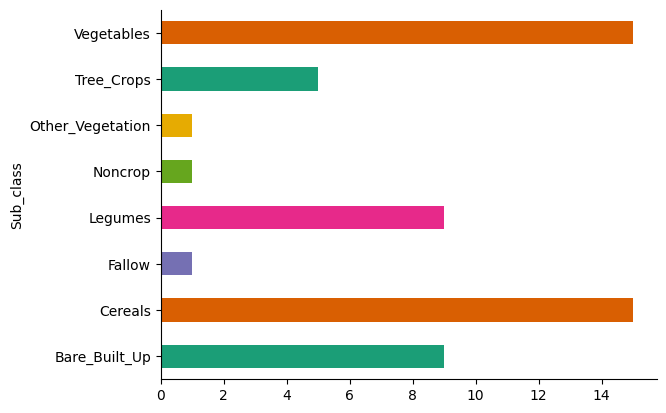

In [ ]:
# @title Sub_class

from matplotlib import pyplot as plt
import seaborn as sns
grouped_df.groupby('Sub_class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-7-5e9d3e1372aa>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(grouped_df, x='Count', y='Sub_class', inner='stick', palette='Dark2')


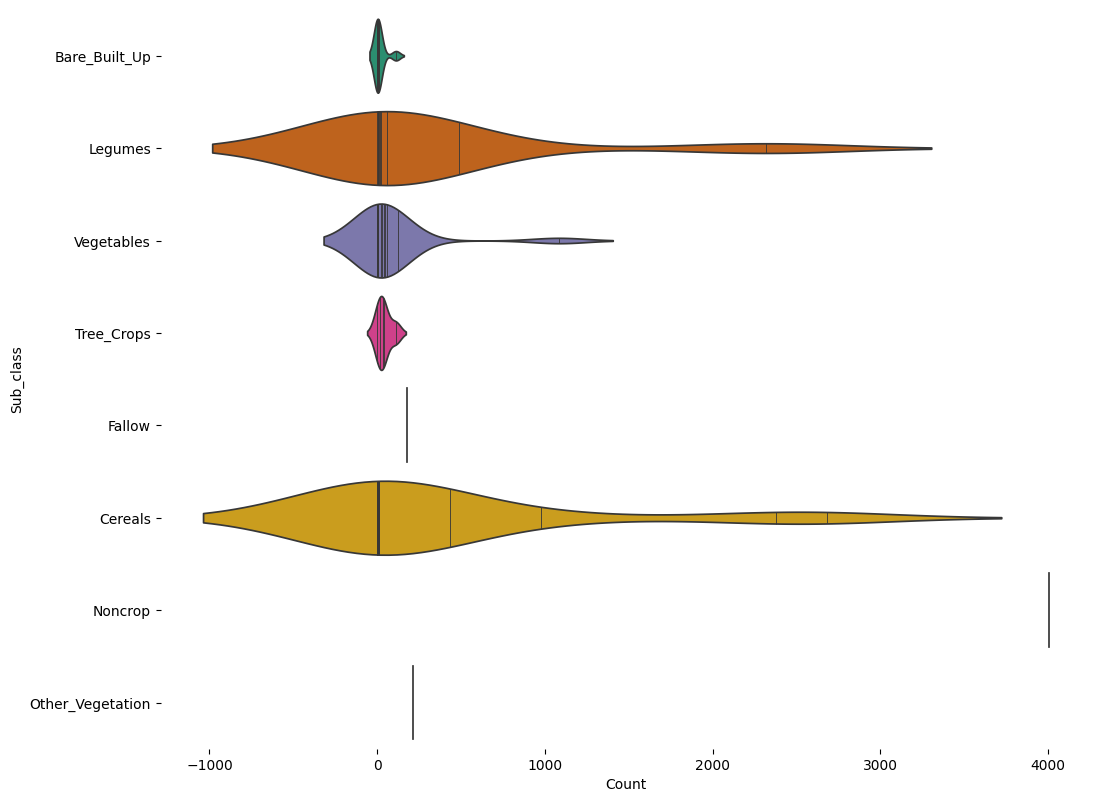

In [ ]:
# @title Sub_class vs Count

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(grouped_df['Sub_class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(grouped_df, x='Count', y='Sub_class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)